In [63]:
# for using the dataset saved in drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# importing the required libraries
import re
import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [65]:
# loading the training dataset
train_df = pd.read_csv("/content/drive/MyDrive/Project JNTUH AIML/train.csv")
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [66]:
# columns,total entries & data type
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [67]:
# distribution of data 
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
# check unique values
train_df.nunique()
# it is a binary classification problem, the classication is either 0 or 1

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

In [69]:
# Loading test data
test_df = pd.read_csv("/content/drive/MyDrive/Project JNTUH AIML/test.csv")
test_df.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [70]:
test_df.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
freq,1,1


In [71]:
# Loading test labels
test_labels_df = pd.read_csv("/content/drive/MyDrive/Project JNTUH AIML/test_labels.csv")
test_labels_df.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [ ]:
test_labels_df[48]

In [72]:
test_labels_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
# Checking the shape of data
print("Training data shape: ",train_df.shape)
print("Testing data shape: ",test_df.shape)
print("Testing label data shape: ",test_labels_df.shape)

Training data shape:  (159571, 8)
Testing data shape:  (153164, 2)
Testing label data shape:  (153164, 7)


In [74]:
# drop id column as not required for analysis
train_df  = train_df.drop(['id'],axis = 1)
test_df   = test_df.drop(['id'],axis = 1)
test_labels_df = test_labels_df.drop(['id'],axis = 1)

In [75]:
# Checking for null values
print("Null values in training set: ")
train_df.isnull().sum()

Null values in training set: 


comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [76]:
print("Null values in testing set: ")
test_df.isnull().sum()

Null values in testing set: 


comment_text    0
dtype: int64

In [77]:
print("Null values in test label set: ")
test_labels_df.isnull().sum()

Null values in test label set: 


toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [78]:
# function to remove certain symbols from text to obtain a cleaner text
def clean_text(line):

    clean = ""
    line = line.replace(",", " ")
    line = line.replace(".", " ")  
    line = line.replace("'", " ")
    line = line.replace(":", " ")
    line = line.replace(";", " ")
    line = line.replace("=", " ")
    line = line.replace("-", " ")
    line = line.replace("+", " ")
    line = line.replace("/", " ")
    line = line.replace("|", " ")
    line = line.replace("!", " ")
    line = line.replace("@", " ")
    line = line.replace("#", " ")
    line = line.replace("$", " ")
    line = line.replace("%", " ")
    line = line.replace("^", " ")
    line = line.replace("*", " ")
    line = line.replace("?", " ")
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in "qwertyuiopasdfghjklzxcvbnm ":
            clean += char
        else:
            clean += " "

    clean = re.sub(" +"," ",clean) #delete extra spaces

    return clean

In [79]:
# clean text
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_text(x))
test_df['comment_text']  = test_df['comment_text'].apply(lambda x: clean_text(x))

In [80]:
# look at some comments
x = train_df["comment_text"].values
print(x)

['explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now '
 'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '
 'hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info '
 ...
 'spitzer umm theres no actual article for prostitution ring crunch captain '
 'and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it '
 ' and i really don t think you understand i came here and my idea was bad right away what kind of community goes you have bad ideas go away instead of helping rewrite them ']


In [81]:
y = train_df[train_df.columns[1:]].values
print(y)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [82]:
x_test = test_df['comment_text'].values
print(x_test)

['yo bitch ja rule is more succesful then you ll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time '
 ' from rfc the title is fine as it is imo '
 ' sources zawe ashton on lapland ' ...
 ' okinotorishima categories i see your changes and agree this is more correct i had gotten confused but then found this while acknowledging japan s territorial rights to okinotorishima itself however is there a category for did not acknowledge japan s claim to an exclusive economic zone eez stemming from okinotorishima that is is there a category for disputed eez s '
 ' one of the founding nations of the eu germany has a law of return quite similar to israel s this isn t actually true is it germany allows people whose ancestors were citizens of 

In [83]:
y_test = test_labels_df.values
print(y_test)

[[-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]]


In [84]:
print("Training data shape: ",x.shape)
print("Training data shape: ",y.shape)
print("Testing data shape: ",x_test.shape)
print("Testing data shape: ",y_test.shape)

Training data shape:  (159571,)
Training data shape:  (159571, 6)
Testing data shape:  (153164,)
Testing data shape:  (153164, 6)


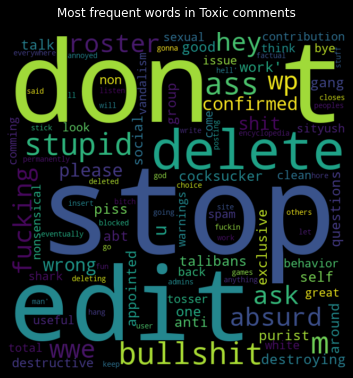

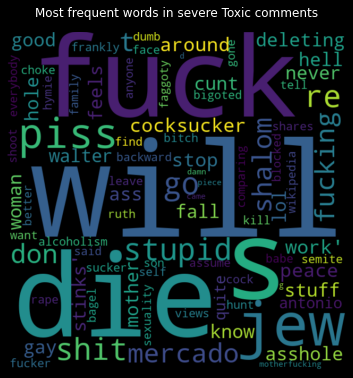

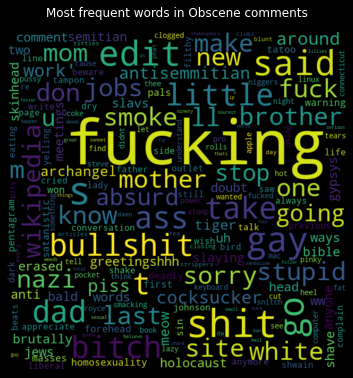

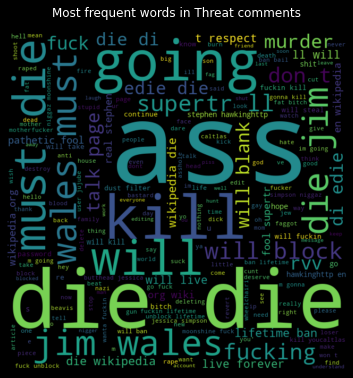

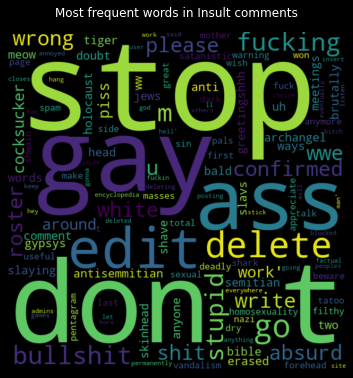

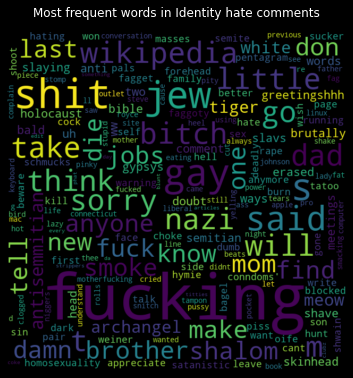

In [85]:
#plot the most frequent words in the dataset using word cloud
#font size is chosen by the frequency of the word in the data 
def word_plot(column,text):
    
    comments = train_df['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxic'], "Toxic comments")
word_plot(train_df['severe_toxic'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['threat'],"Threat comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['identity_hate'],"Identity hate comments")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


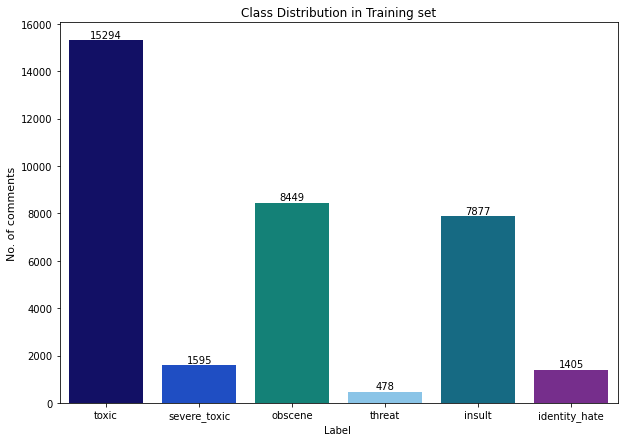

In [86]:
colors_ = ["deep blue","blue", "teal", "lightblue","sea blue","purple"]

palette= sns.xkcd_palette(colors_)

n = train_df.iloc[:,1:].sum()

plt.figure(figsize=(10,7))

ax= sns.barplot(n.index, n.values,palette=palette)
plt.title("Class Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

patch = ax.patches
labels = n.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

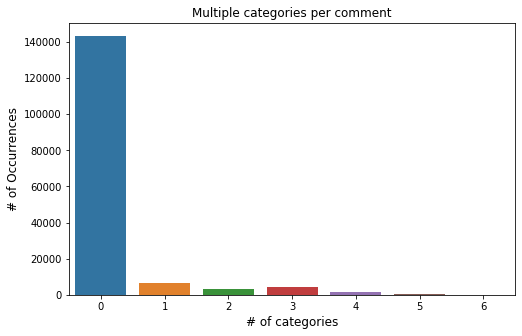

In [87]:
rowsums = train_df.iloc[:,1:].sum(axis=1)
m=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(m.index, m.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [88]:
print('Percentage of comments that are not labelled:')
print(len(train_df[(train_df['toxic']==0) & (train_df['severe_toxic']==0) & (train_df['obscene']==0) & (train_df['threat']== 0) & (train_df['insult']==0) & (train_df['identity_hate']==0)]) / len(train_df))

Percentage of comments that are not labelled:
0.8983211235124177


In [89]:
max_features = 20000 # most freq 20k words in the dataset would be kept
max_text_length = 400

In [90]:
# change each text into a sequence of integers, each integer being index of token in a dictionary
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized,maxlen = max_text_length) #padding so that all comments have same lenght of 400

In [91]:
#tokenise and pad the text in test dataset so that all comments are sequences have the same lenght of 400
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen = max_text_length)

In [62]:
# code to download glove data
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-09-21 10:50:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-21 10:50:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-21 10:50:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [92]:
embedding_dim = 100
embeddings_index = dict()

f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float32') #store all excepy val[0]
    embeddings_index[word] = coefs #populate embedding dict
    
f.close()

print(f'Found {len(embeddings_index)} word vectors') 

Found 400000 word vectors


In [93]:
# prepare embedding_matrix
embedding_matrix = np.zeros((max_features,embedding_dim))

for word,index in x_tokenizer.word_index.items():
    
    if index> max_features -1: #bounding by max feat
        break
    else:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [94]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.18970001  0.050024    0.19084001 ... -0.39804     0.47646999
  -0.15983   ]
 ...
 [ 0.52485001  0.13468    -0.80821002 ... -0.24451999  0.29423001
   0.23480999]
 [ 0.30212     0.47141999 -0.16118    ... -0.079104    0.31779
   0.59662998]
 [-0.046447   -0.28845     0.55619001 ...  0.04914     0.46781
   0.17200001]]


In [95]:
x_train_val

array([[    0,     0,     0, ...,    69,  3226,    90],
       [    0,     0,     0, ...,    38,   944,   183],
       [    0,     0,     0, ...,     1,   710,   462],
       ...,
       [    0,     0,     0, ...,  3297, 12699,  4181],
       [    0,     0,     0, ...,   154,    36,    10],
       [    0,     0,     0, ...,  1563,  1966,    89]], dtype=int32)

In [97]:
# Train Test Split
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y,
                                              test_size = 0.2,
                                              shuffle = True,
                                              random_state = 1)

In [98]:
print("Training Data Shape: ")
print(x_train.shape, y_train.shape)

Training Data Shape: 
(127656, 400) (127656, 6)


In [99]:
print("Validation Data Shape: ")
print(x_val.shape, y_val.shape)

Validation Data Shape: 
(31915, 400) (31915, 6)


In [104]:
embedding_dim = 100
max_features = 20000

filters = 250 
kernel_size = 3
hidden_dims = 250
batch_size = 32
n_epochs = 4
drop_rate = 0.4

In [105]:

model = Sequential()
    
#create embedding layer
model.add(Embedding(max_features, embedding_dim, trainable = False
                       , embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))    
# 1st dropout
model.add(Dropout(drop_rate))
    
# 1st convolutional 1-D layer
model.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu')) 
  
#max pooling layer
model.add(MaxPooling1D())
    
# 2nd convolutional 1-D layer
model.add(Conv1D(filters, kernel_size, padding = 'valid', activation = 'relu'))
    
# global max pooling layer
model.add(GlobalMaxPooling1D())
    
# 1st dense layer
model.add(Dense(hidden_dims, activation = 'relu'))
    
# 2nd dropout
model.add(Dropout(drop_rate))
    
# final dense layer
model.add(Dense(6,activation = 'sigmoid'))
    


In [106]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 250)         75250     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 250)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 250)         187750    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                         

In [108]:
# compile the model
model.compile(loss = 'binary_crossentropy', 
                 optimizer = 'adam',
                 metrics = ['accuracy']) 

In [109]:
# fit the model
model.fit(x_train,y_train,
          batch_size = batch_size, 
          epochs = n_epochs, 
          validation_data=(x_val,y_val))


Epoch 1/4
3990/3990 [==============================] - 1139s 285ms/step - loss: 0.0663 - accuracy: 0.9585 - val_loss: 0.0540 - val_accuracy: 0.9937
Epoch 2/4
3990/3990 [==============================] - 1113s 279ms/step - loss: 0.0536 - accuracy: 0.9823 - val_loss: 0.0507 - val_accuracy: 0.9932
Epoch 3/4
3990/3990 [==============================] - 1146s 287ms/step - loss: 0.0500 - accuracy: 0.9678 - val_loss: 0.0510 - val_accuracy: 0.9946
Epoch 4/4
3990/3990 [==============================] - 1138s 285ms/step - loss: 0.0477 - accuracy: 0.9659 - val_loss: 0.0510 - val_accuracy: 0.9919


In [110]:
model.evaluate(x_val, y_val, verbose=0)

[0.05104605108499527, 0.9918533563613892]

In [113]:
# predict test values
y_pred = model.predict(x_testing, verbose = 1, batch_size = 32)

4787/4787 [==============================] - 399s 83ms/step


In [114]:
y_pred

array([[9.9922550e-01, 4.7252524e-01, 9.6249926e-01, 4.7622129e-01,
        9.0291786e-01, 4.7053704e-01],
       [5.3158402e-04, 6.8079473e-08, 2.5985399e-05, 4.1927429e-08,
        3.4279015e-05, 5.6260188e-07],
       [4.3861568e-03, 3.8732665e-06, 4.5093894e-04, 2.8781187e-05,
        4.0987134e-04, 1.1596767e-05],
       ...,
       [3.2380223e-04, 1.7552853e-08, 6.3411799e-06, 6.1942742e-08,
        7.1311301e-06, 3.0631745e-07],
       [2.9105037e-02, 7.4766787e-05, 4.5314431e-04, 1.2339845e-05,
        1.4115274e-03, 1.9824326e-02],
       [9.9351507e-01, 1.1997381e-01, 9.2337835e-01, 5.0830245e-03,
        8.1151128e-01, 5.8645546e-02]], dtype=float32)

In [115]:
y_pred[0] 

array([0.9992255 , 0.47252524, 0.96249926, 0.4762213 , 0.90291786,
       0.47053704], dtype=float32)

In [116]:
y_test[0]

array([-1, -1, -1, -1, -1, -1])

In [117]:
y_pred[21]

array([0.63047564, 0.04060882, 0.10510978, 0.06106529, 0.15748248,
       0.2522621 ], dtype=float32)

In [118]:
y_test[21]

array([1, 0, 0, 0, 0, 0])

In [120]:
y_pred[48]

array([0.9990324 , 0.41315103, 0.9769789 , 0.01857615, 0.9121316 ,
       0.6632112 ], dtype=float32)

In [119]:
y_test[48]

array([1, 0, 1, 0, 1, 1])